# OLI Content Extraction and Analysis

In [1]:
import pandas as pd
import numpy as np
import textract
import re, json, os
from os.path import join
from bs4 import BeautifulSoup
from gensim.summarization import keywords  #must use version 3.8.3 of gensim because gensim.summarization was deprecated in version 4.0.0
import warnings
warnings.filterwarnings("ignore")

c:\Users\peter\AppData\Local\Programs\Python\Python310\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used


## 1. Extract content from PDF file

In [3]:
def extract_content_from_pdf(filename):
    # text variable which contains all the text derived from our PDF file
    full_text = textract.process(filename, method='pdfminer', language='eng').decode('utf-8')
    return full_text.encode('ascii','ignore').lower().decode('utf-8')

def extract_keyword(full_text):
    keyword_summaries = keywords(text = full_text, split = "\n", scores = True)
    data = pd.DataFrame(keyword_summaries, columns = ["keyword", "score"])
    return data.sort_values("score", ascending = False)

## 2. Extract content from XML files 

In [2]:
SEMESTER = "s23"
oli_org = open(f'{SEMESTER}/organizations/default/organization.xml', "r").read()
oli_org_soup = BeautifulSoup(oli_org, "lxml")

In [3]:
def get_module_unit_from_org(page_id):
    try:
        resource_ref = oli_org_soup.find('resourceref', {'idref': page_id})
        curr_module = resource_ref.find_parent('module').find('title').get_text()
        curr_unit = resource_ref.find_parent('unit').find('title').get_text()
        return curr_module, curr_unit
    except:
        return None, None

def is_header(p):
    # a header paragraph should have the form <p><em>...</em></p>, with no other inner tag
    n_contents = len([c for c in p.contents if not str(c.string).isspace()])
    return p.find("em") is not None and n_contents == 1

def get_file_content(filename):
    with open(file = f'{SEMESTER}/content/x-oli-workbook_page/' + filename, encoding='utf-8') as file:
        soup = BeautifulSoup(file.read(), 'lxml', from_encoding='utf-8')
    page_id = soup.find('workbook_page')['id']
    curr_module, curr_unit = get_module_unit_from_org(page_id)
    title = soup.find("title").get_text().strip()   
    if curr_module:
        curr_module = re.sub(r"\t+", r"", curr_module.strip())
    # extract the sub-headers <p><em>text</em></p> and remove them from the text content
    sub_headers = []
    for p in soup.find_all("p"):
        if is_header(p):
            sub_headers.append(p.find("em").get_text().strip())
            p.extract()
    
    all_text = "\n".join(p.get_text().strip() for p in soup.find_all("p")[1:])
    
    all_text = re.sub(r"\n+", r"\n", all_text.strip())
    pattern = r"\\\w+\d+"

    all_text = re.sub(pattern, "", all_text)
    
    all_text = all_text.replace("$", "")
    all_text = all_text.replace("\\n",'')
    all_text = all_text.replace("\\t",'')
    all_text = all_text.replace("\\r",'')
    all_text = all_text.replace("\\xcf",'')
    all_text = all_text.replace('http://cnx.org/contents/85abf193-2bd2-4908-8563-90b8a7ac8df6@9.312', '')
    return {
        "Unit" : curr_unit, "Module" : curr_module, "Title" : title,
        "Text": all_text, "Subheaders" : ",".join(sub_headers)
    }

In [5]:
df_oli = pd.DataFrame([
    get_file_content(filename)
    for filename in os.listdir(f"{SEMESTER}/content/x-oli-workbook_page")
    if filename.endswith(".xml")
]).dropna()
df_oli.to_csv("chem_oli_content.csv", index = False, encoding='utf-8')
display(df_oli)

,Unit,Module,Title,Text,Subheaders
2,Composition of Substances and Solutions,Introduction,Introduction to Composition of Substances and ...,Swimming pools have long been a popular means ...,
3,Chemical Bonding and Molecular Geometry,Introduction,Introduction to Chemical Bonding and Molecular...,It has long been known that pure carbon occurs...,
4,Electronic Structure and Periodic Properties,Introduction,Electronic Structure and Periodic Properties I...,The Crab Nebula consists of remnan...,
5,Gases,Introduction,Introduction to Gases,We are surrounded by an ocean of gasthe atmosp...,
7,Reactions and Stoichiometry,Introduction,Introduction to Chemical Reactions and Stoichi...,Solid-fuel rockets are a central feature in th...,
...,...,...,...,...,...
266,Composition of Substances and Solutions,The Mole,Module Summary and Quiz,The formula mass of a substance is the sum of ...,
267,Foundations of Chemistry,Elements and Compounds,Nomenclature for Ionic Compounds with Polyatom...,The ions that we have discussed so far are cal...,
268,Reactions and Stoichiometry,Chemical Reactions and Equations,Module Summary and Quiz,Chemical equations are symbolic representation...,
269,Foundations of Chemistry,Measurements,Temperature Conversions,We use the word temperature to refer to the ho...,


In [40]:
df_oli['Module'] = df_oli['Module'].str.replace('\t' ,'')
display(df_oli)

,Unit,Module,Title,Text,Subheaders
2,Composition of Substances and Solutions,Introduction,Introduction to Composition of Substances and ...,Swimming pools have long been a popular means ...,
3,Chemical Bonding and Molecular Geometry,Introduction,Introduction to Chemical Bonding and Molecular...,It has long been known that pure carbon occurs...,
4,Electronic Structure and Periodic Properties,Introduction,Electronic Structure and Periodic Properties I...,\n The Crab Nebula consists of remn...,
5,Gases,Introduction,Introduction to Gases,We are surrounded by an ocean of gasthe atmosp...,
7,Reactions and Stoichiometry,Introduction,Introduction to Chemical Reactions and Stoichi...,Solid-fuel rockets are a central feature in th...,
...,...,...,...,...,...
266,Composition of Substances and Solutions,The Mole,Module Summary and Quiz,The formula mass of a substance is the sum of ...,
267,Foundations of Chemistry,Elements and Compounds,Nomenclature for Ionic Compounds with Polyatom...,The ions that we have discussed so far are cal...,
268,Reactions and Stoichiometry,\r\n\t\t\t\t\t\tChemical Reactions and Equations,Module Summary and Quiz,Chemical equations are symbolic representation...,
269,Foundations of Chemistry,Measurements,Temperature Conversions,We use the word temperature to refer to the ho...,


## 3. Topic modeling with LDA

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
df_oli = pd.read_csv('chem_oli_content.csv')

[('atoms', 608), ('electrons', 543), ('energy', 488), ('atom', 452), ('mathrm', 436), ('molecules', 423), ('water', 409), ('electron', 393), ('mass', 392), ('gas', 385)]


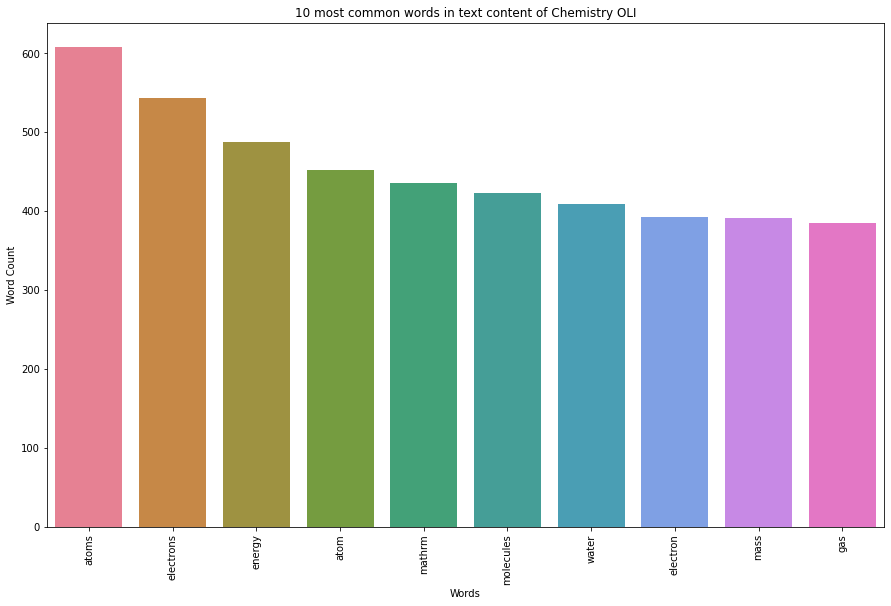

In [10]:
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    # get the count of each word across the entire corpus
    total_counts = count_data.sum(axis = 0).A.ravel()

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[0:10]
    words, counts = zip(*count_dict)
    print(count_dict)
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words in text content of Chemistry OLI')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x=x_pos, y=list(counts), palette='husl')
    plt.xticks(x_pos, list(words), rotation=90) 
    plt.xlabel('Words')
    plt.ylabel('Word Count')
    plt.show()

# Preprocess the text to prepare for LDA
df_oli["Cleaned Text"] = df_oli["Text"].apply(lambda text: re.sub('[,\.!?]', '', text).lower())
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df_oli['Cleaned Text'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

Foundations of Chemistry                        38
Chemical Bonding and Molecular Geometry         34
Electronic Structure and Periodic Properties    24
Gases                                           24
Solids and Liquids                              24
Name: Unit, dtype: int64

Text(0.5, 1.0, 'Count of Paragraphs in Each Unit Chemistry Data')

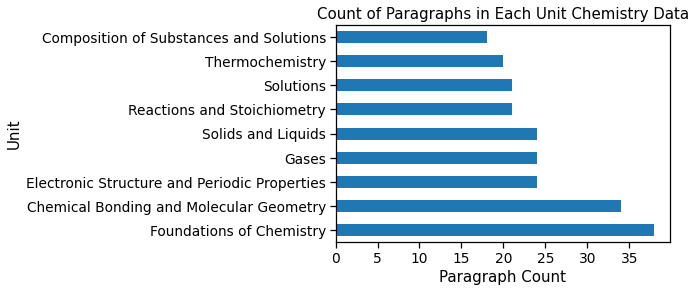

In [12]:
fig, ax = plt.subplots()
display(df_oli['Unit'].value_counts().head())
df_oli['Unit'].value_counts().plot(ax=ax, kind='barh')
ax.axes.set_xlabel('Paragraph Count')
ax.axes.set_ylabel('Unit')
ax.axes.set_title('Count of Paragraphs in Each Unit Chemistry Data')

In [16]:
df_oli.Module.replace('\r\n\t\t\t\t\t\tChemical Reactions and Equations', 'Chemical Reactions and Equations', inplace=True)

Elements and Compounds              14
Measurements                        11
Chemical Reactions and Equations    11
Solubility                          11
Quantum Theory                      10
Name: Module, dtype: int64

Text(0.5, 1.0, 'Count of Paragraphs in Each Module Chemistry Data')

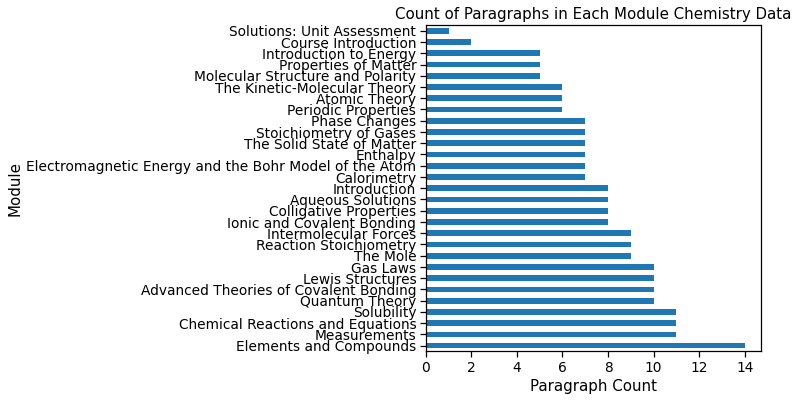

In [44]:
fig, ax = plt.subplots()
fig.set_size_inches(6,6)
display(df_oli['Module'].value_counts().head())
df_oli['Module'].value_counts().plot(ax=ax, kind='barh')
ax.axes.set_xlabel('Paragraph Count')
ax.axes.set_ylabel('Module')
ax.axes.set_title('Count of Paragraphs in Each Module Chemistry Data')

## 4. QA generation with pretrained huggingface model


In [45]:
from pipelines import pipeline
question_generator = pipeline("e2e-qg");

In [24]:
def generate_question_by_paragraph(df):
    df["Paragraph"] = df["Text"].str.split("\n")
    df_para = df.explode("Paragraph")
    df_para["Generated Question"] = df_para["Paragraph"].apply(question_generator)
    return df_para.explode("Generated Question")

In [25]:
df_oli_with_questions = generate_question_by_paragraph(df_oli)

In [26]:
df_oli_with_questions = df_oli_with_questions[df_oli_with_questions['Text']!= '']

In [27]:
df_oli_with_questions.drop(columns = "Text").to_csv("chem_oli_content_with_questions.csv", index = False)

In [28]:
df_oli_with_questions.reset_index()

,index,Unit,Module,Title,Text,Subheaders,Cleaned Text,Paragraph,Generated Question
0,2,Composition of Substances and Solutions,Introduction,Introduction to Composition of Substances and ...,Swimming pools have long been a popular means ...,,swimming pools have long been a popular means ...,Swimming pools have long been a popular means ...,"What is a popular means of recreation, exercis..."
1,2,Composition of Substances and Solutions,Introduction,Introduction to Composition of Substances and ...,Swimming pools have long been a popular means ...,,swimming pools have long been a popular means ...,Swimming pools have long been a popular means ...,What is regularly treated with chemicals to pr...
2,2,Composition of Substances and Solutions,Introduction,Introduction to Composition of Substances and ...,Swimming pools have long been a popular means ...,,swimming pools have long been a popular means ...,Swimming pools have long been a popular means ...,"How is the relative amount of calcium ion, Ca2..."
3,3,Chemical Bonding and Molecular Geometry,Introduction,Introduction to Chemical Bonding and Molecular...,It has long been known that pure carbon occurs...,,it has long been known that pure carbon occurs...,It has long been known that pure carbon occurs...,When was a new form of carbon recognized?
4,3,Chemical Bonding and Molecular Geometry,Introduction,Introduction to Chemical Bonding and Molecular...,It has long been known that pure carbon occurs...,,it has long been known that pure carbon occurs...,It has long been known that pure carbon occurs...,What was the name of the molecule that was nam...
...,...,...,...,...,...,...,...,...,...
5403,269,Foundations of Chemistry,Measurements,Temperature Conversions,We use the word temperature to refer to the ho...,,we use the word temperature to refer to the ho...,"You are visiting Paris, France and you see tha...",What is the high temperature for the day in Pa...
5404,269,Foundations of Chemistry,Measurements,Temperature Conversions,We use the word temperature to refer to the ho...,,we use the word temperature to refer to the ho...,"You are visiting Paris, France and you see tha...",What temperature is in °F and K?
5405,269,Foundations of Chemistry,Measurements,Temperature Conversions,We use the word temperature to refer to the ho...,,we use the word temperature to refer to the ho...,Adapted from Openstax Chemistry under Creativ...,Adapted from Openstax Chemistry under Creative...
5406,269,Foundations of Chemistry,Measurements,Temperature Conversions,We use the word temperature to refer to the ho...,,we use the word temperature to refer to the ho...,Download for free at http://cnx.org/contents/8...,What is a free download for free?


In [29]:
display(df_oli_with_questions.head())

,Unit,Module,Title,Text,Subheaders,Cleaned Text,Paragraph,Generated Question
2,Composition of Substances and Solutions,Introduction,Introduction to Composition of Substances and ...,Swimming pools have long been a popular means ...,,swimming pools have long been a popular means ...,Swimming pools have long been a popular means ...,"What is a popular means of recreation, exercis..."
2,Composition of Substances and Solutions,Introduction,Introduction to Composition of Substances and ...,Swimming pools have long been a popular means ...,,swimming pools have long been a popular means ...,Swimming pools have long been a popular means ...,What is regularly treated with chemicals to pr...
2,Composition of Substances and Solutions,Introduction,Introduction to Composition of Substances and ...,Swimming pools have long been a popular means ...,,swimming pools have long been a popular means ...,Swimming pools have long been a popular means ...,"How is the relative amount of calcium ion, Ca2..."
3,Chemical Bonding and Molecular Geometry,Introduction,Introduction to Chemical Bonding and Molecular...,It has long been known that pure carbon occurs...,,it has long been known that pure carbon occurs...,It has long been known that pure carbon occurs...,When was a new form of carbon recognized?
3,Chemical Bonding and Molecular Geometry,Introduction,Introduction to Chemical Bonding and Molecular...,It has long been known that pure carbon occurs...,,it has long been known that pure carbon occurs...,It has long been known that pure carbon occurs...,What was the name of the molecule that was nam...


In [34]:
df_oli_with_questions.reset_index().iloc[201, [-2, -1]].tolist()

['As was the case for gaseous substances , the kinetic molecular\\n            theory may be used to explain the behavior of solids and liquids. In the following\\n            description, the term particle will be used to refer to an atom, molecule, or ion.',
 'What theory may be used to explain the behavior of solids and liquids?']

In [46]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("voidful/context-only-question-generator")

model = AutoModelForSeq2SeqLM.from_pretrained("voidful/context-only-question-generator")

In [55]:
def generate(content):
    return model.generate(content)

def generate_question_by_paragraph(df):
    df["Paragraph"] = df["Text"].str.split("\n")
    df_para = df.explode("Paragraph")
    df_para["Generated Question"] = df_para["Paragraph"].apply(lambda x: generate(tokenizer.tokenize(x)))
    return df_para.explode("Generated Question")

In [56]:
generate_question_by_paragraph(df_oli)

AttributeError: 'list' object has no attribute 'shape'